In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import exp

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("Librerías cargadas correctamente")


Librerías cargadas correctamente


In [3]:
# Cargar datos consolidados
data = pd.read_csv('../data/consolidated_data.csv')

# Ver estructura básica
print("Datos cargados:")
print(f"Total registros: {len(data)}")
print(f"Estaciones: {data['Station'].unique()}")
print(f"Columnas: {list(data.columns)}")

# Mostrar primeras filas
data.head()


Datos cargados:
Total registros: 60
Estaciones: [1 2 3 4]
Columnas: ['Station', 'Record_No', 'Distance_m', 'Structure_Type', 'Dip_Direction_degrees', 'Dip_degrees', 'Spacing_mm', 'Persistence_m', 'Termination', 'Aperture_mm', 'Infilling_Type', 'Infilling_Thickness', 'Roughness', 'Waviness', 'Weathering', 'Groundwater', 'Number_Joints', 'Observations']


,Station,Record_No,Distance_m,Structure_Type,Dip_Direction_degrees,Dip_degrees,Spacing_mm,Persistence_m,Termination,Aperture_mm,Infilling_Type,Infilling_Thickness,Roughness,Waviness,Weathering,Groundwater,Number_Joints,Observations
0,1,1,0.00,J,248,57,4,1,1,3,3,3,4,2,1,1,1.0,NaN
1,1,2,0.15,J,225,67,4,1,1,3,5,5,4,2,1,1,4.0,NaN
2,1,3,0.30,J,239,65,5,1,1,4,1,1,4,2,1,1,4.0,NaN
3,1,4,0.52,J,250,61,5,1,1,2,5,5,4,2,1,1,4.0,NaN
4,1,5,0.63,J,215,65,5,1,1,3,5,5,4,2,1,1,4.0,NaN


In [4]:
# PASO 1: Definir parámetros fijos y tablas de conversión

# 1. Resistencia a compresión (R4 - Roca dura)
ucs_mpa = 75  # MPa (valor medio de 50-100 MPa)
rating_ucs = 7  # Rating según tabla RMR para 50-100 MPa

# 2. Tabla de conversión Persistencia (desde códigos)
persistence_conversion = {
    1: 0.5,   # <1m → 0.5m (valor medio)
    2: 2.0,   # 1-3m → 2.0m (valor medio) 
    3: 6.5,   # 3-10m → 6.5m (valor medio)
    4: 15.0,  # 10-20m → 15.0m (valor medio)
    5: 25.0   # >20m → 25.0m (estimado)
}

# 3. Función para calcular RQD desde frecuencia de discontinuidades
def calculate_rqd_from_frequency(num_discontinuities, total_length_m):
    """
    Calcula RQD usando la fórmula empírica de Priest & Hudson (1976):
    RQD = 100 * e^(-0.1λ) * (0.1λ + 1)
    donde λ = frecuencia de discontinuidades por metro
    """
    if total_length_m <= 0:
        return 0
    
    lambda_freq = num_discontinuities / total_length_m
    rqd = 100 * exp(-0.1 * lambda_freq) * (0.1 * lambda_freq + 1)
    
    # Limitar entre 0 y 100
    return max(0, min(100, rqd))

print("Parámetros y funciones definidos:")
print(f"UCS: {ucs_mpa} MPa (Rating: {rating_ucs})")
print(f"Conversión persistencia: {persistence_conversion}")
print("Función RQD lista")


Parámetros y funciones definidos:
UCS: 75 MPa (Rating: 7)
Conversión persistencia: {1: 0.5, 2: 2.0, 3: 6.5, 4: 15.0, 5: 25.0}
Función RQD lista


In [5]:
# PASO 2: Calcular parámetros por estación

# Análisis por estación
stations_analysis = []

for station in data['Station'].unique():
    df_station = data[data['Station'] == station].copy()
    
    # Parámetros básicos
    num_discontinuities = len(df_station)
    total_length = df_station['Distance_m'].max()
    
    # Calcular RQD
    rqd = calculate_rqd_from_frequency(num_discontinuities, total_length)
    
    # Convertir persistencia a metros
    df_station['Persistence_m_real'] = df_station['Persistence_m'].map(persistence_conversion)
    persistence_average = df_station['Persistence_m_real'].mean()
    
    # Calcular espaciado promedio (convertir códigos a mm)
    spacing_conversion = {1: 10, 2: 40, 3: 130, 4: 400, 5: 800}  # valores medios en mm
    df_station['Spacing_mm_real'] = df_station['Spacing_mm'].map(spacing_conversion)
    spacing_average = df_station['Spacing_mm_real'].mean()
    
    # Guardar resultados
    stations_analysis.append({
        'Station': station,
        'Num_Discontinuities': num_discontinuities,
        'Total_Length_m': total_length,
        'Frequency_disc_per_m': num_discontinuities / total_length if total_length > 0 else 0,
        'RQD_calculated': rqd,
        'Persistence_average_m': persistence_average,
        'Spacing_average_mm': spacing_average
    })

# Convertir a DataFrame
df_stations = pd.DataFrame(stations_analysis)
print("Análisis por estación:")
print(df_stations)


Análisis por estación:
   Station  Num_Discontinuities  Total_Length_m  Frequency_disc_per_m  \
0        1                   15            2.14              7.009346   
1        2                   15            3.06              4.901961   
2        3                   15            2.38              6.302521   
3        4                   15            2.21              6.787330   

   RQD_calculated  Persistence_average_m  Spacing_average_mm  
0       84.387008                    0.9          443.333333  
1       91.275446                    3.2          389.333333  
2       86.804004                    1.6          452.666667  
3       85.155289                    1.4          800.000000  


In [6]:
# PASO 3: Funciones de rating RMR14

def get_rqd_rating(rqd):
    """Rating RQD según RMR14"""
    if rqd >= 90:
        return 20
    elif rqd >= 75:
        return 17
    elif rqd >= 50:
        return 13
    elif rqd >= 25:
        return 8
    else:
        return 3

def get_spacing_rating(spacing_mm):
    """Rating espaciado según RMR14"""
    if spacing_mm >= 2000:
        return 20
    elif spacing_mm >= 600:
        return 15
    elif spacing_mm >= 200:
        return 10
    elif spacing_mm >= 60:
        return 8
    else:
        return 5

def get_persistence_rating(persistence_m):
    """Rating persistencia según RMR14"""
    if persistence_m < 1:
        return 6
    elif persistence_m < 3:
        return 4
    elif persistence_m < 10:
        return 2
    elif persistence_m < 20:
        return 1
    else:
        return 0

# Función para obtener rating de condiciones de discontinuidades (simplificada)
def get_discontinuity_condition_rating(aperture_code, roughness_code, weathering_code, infilling_code):
    """
    Rating simplificado de condiciones de discontinuidades
    Basado en códigos promedio de apertura, rugosidad, meteorización y relleno
    """
    # Conversión simplificada a rating (ajustable según criterio geotécnico)
    base_rating = 30  # Rating máximo para condiciones muy buenas
    
    # Penalización por apertura (1=cerrado, 5=muy abierto)
    aperture_penalty = (aperture_code - 1) * 2
    
    # Penalización por rugosidad (1=muy rugoso, 5=liso)
    roughness_penalty = (roughness_code - 1) * 1.5
    
    # Penalización por meteorización (1=fresco, 5=descompuesto)
    weathering_penalty = (weathering_code - 1) * 3
    
    # Penalización por relleno (ajustado según tipo)
    if infilling_code <= 2:  # Limpio o cuarzo
        infilling_penalty = 0
    elif infilling_code == 3:  # Arcilla
        infilling_penalty = 5
    else:  # Otros rellenos
        infilling_penalty = 3
    
    total_rating = base_rating - aperture_penalty - roughness_penalty - weathering_penalty - infilling_penalty
    
    # Limitar entre 0 y 30
    return max(0, min(30, total_rating))

def get_groundwater_rating(groundwater_code):
    """Rating condiciones de agua subterránea"""
    ratings = {1: 15, 2: 10, 3: 7, 4: 4, 5: 0}  # 1=seco, 5=fluyendo
    return ratings.get(groundwater_code, 7)

print("Funciones de rating RMR14 definidas")


Funciones de rating RMR14 definidas


In [7]:
# PASO 4: Calcular RMR14 para cada estación

rmr_results = []

for station in data['Station'].unique():
    df_station = data[data['Station'] == station].copy()
    station_info = df_stations[df_stations['Station'] == station].iloc[0]
    
    # Parámetro 1: Resistencia de la roca intacta
    rating_strength = rating_ucs  # 7 puntos (R4 - 75 MPa)
    
    # Parámetro 2: RQD
    rqd = station_info['RQD_calculated']
    rating_rqd = get_rqd_rating(rqd)
    
    # Parámetro 3: Espaciado de discontinuidades
    spacing_avg = station_info['Spacing_average_mm']
    rating_spacing = get_spacing_rating(spacing_avg)
    
    # Parámetro 4: Condición de las discontinuidades
    aperture_avg = df_station['Aperture_mm'].mean()
    roughness_avg = df_station['Roughness'].mean()
    weathering_avg = df_station['Weathering'].mean()
    infilling_avg = df_station['Infilling_Type'].mean()
    
    rating_conditions = get_discontinuity_condition_rating(
        aperture_avg, roughness_avg, weathering_avg, infilling_avg
    )
    
    # Parámetro 5: Agua subterránea
    groundwater_avg = df_station['Groundwater'].mean()
    rating_groundwater = get_groundwater_rating(int(groundwater_avg))
    
    # Ajuste por orientación (simplificado - asumimos orientación desfavorable)
    orientation_adjustment = -5  # Penalización por orientación desfavorable
    
    # RMR14 total
    rmr_total = (rating_strength + rating_rqd + rating_spacing + 
                rating_conditions + rating_groundwater + orientation_adjustment)
    
    # Clasificación geomecánica
    if rmr_total >= 81:
        classification = "Clase I - Muy buena"
    elif rmr_total >= 61:
        classification = "Clase II - Buena"
    elif rmr_total >= 41:
        classification = "Clase III - Regular"
    elif rmr_total >= 21:
        classification = "Clase IV - Mala"
    else:
        classification = "Clase V - Muy mala"
    
    # Guardar resultados
    rmr_results.append({
        'Station': station,
        'UCS_Rating': rating_strength,
        'RQD_Value': round(rqd, 1),
        'RQD_Rating': rating_rqd,
        'Spacing_mm': round(spacing_avg, 1),
        'Spacing_Rating': rating_spacing,
        'Conditions_Rating': round(rating_conditions, 1),
        'Groundwater_Rating': rating_groundwater,
        'Orientation_Adj': orientation_adjustment,
        'RMR14_Total': rmr_total,
        'Classification': classification
    })

# Convertir a DataFrame
df_rmr = pd.DataFrame(rmr_results)

print("RESULTADOS RMR14:")
print("="*60)
for _, row in df_rmr.iterrows():
    print(f"\n{row['Station']}:")
    print(f"  • RMR14 Total: {row['RMR14_Total']}")
    print(f"  • Clasificación: {row['Classification']}")
    print(f"  • RQD: {row['RQD_Value']}% (Rating: {row['RQD_Rating']})")
    print(f"  • Espaciado: {row['Spacing_mm']}mm (Rating: {row['Spacing_Rating']})")

print("\n" + "="*60)
print("\nTabla completa:")
print(df_rmr)


RESULTADOS RMR14:

1:
  • RMR14 Total: 63.099999999999994
  • Clasificación: Clase II - Buena
  • RQD: 84.4% (Rating: 17)
  • Espaciado: 443.3mm (Rating: 10)

2:
  • RMR14 Total: 64.23333333333333
  • Clasificación: Clase II - Buena
  • RQD: 91.3% (Rating: 20)
  • Espaciado: 389.3mm (Rating: 10)

3:
  • RMR14 Total: 61.8
  • Clasificación: Clase II - Buena
  • RQD: 86.8% (Rating: 17)
  • Espaciado: 452.7mm (Rating: 10)

4:
  • RMR14 Total: 76.3
  • Clasificación: Clase II - Buena
  • RQD: 85.2% (Rating: 17)
  • Espaciado: 800.0mm (Rating: 15)


Tabla completa:
   Station  UCS_Rating  RQD_Value  RQD_Rating  Spacing_mm  Spacing_Rating  \
0        1           7       84.4          17       443.3              10   
1        2           7       91.3          20       389.3              10   
2        3           7       86.8          17       452.7              10   
3        4           7       85.2          17       800.0              15   

   Conditions_Rating  Groundwater_Rating  Orien

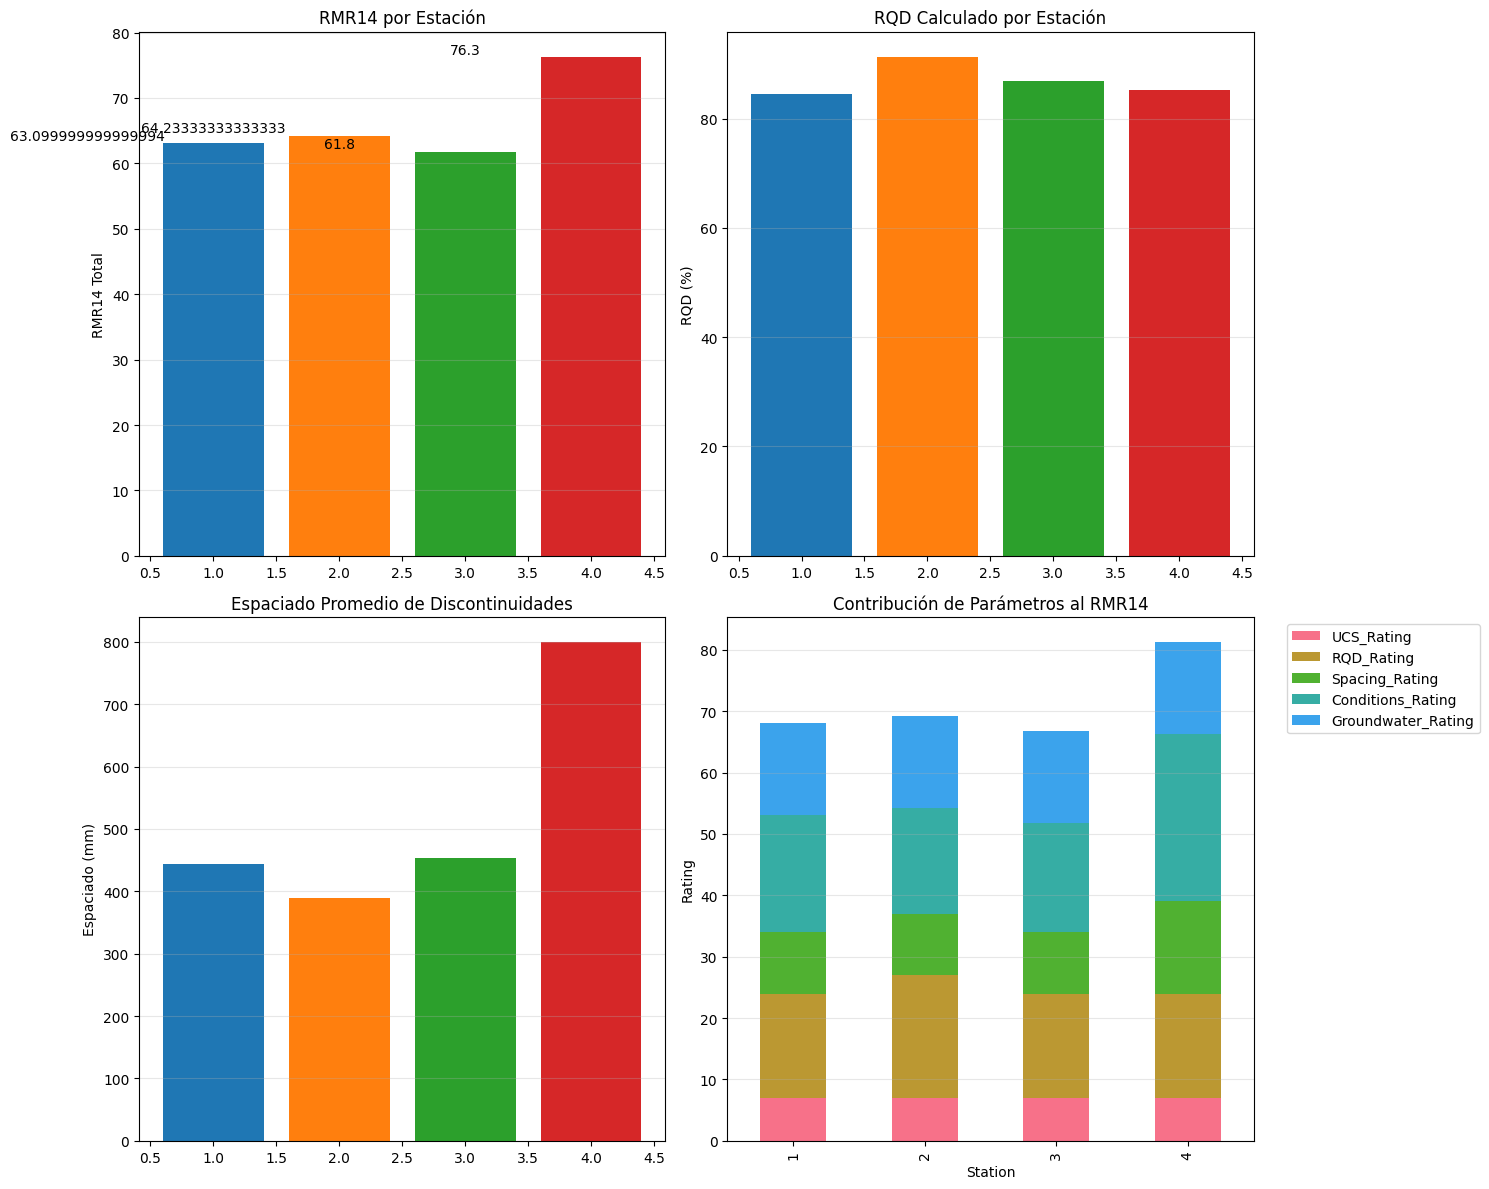


ESTADÍSTICAS RESUMIDAS:
RMR14 promedio: 66.4
RMR14 mínimo: 61.8 (3)
RMR14 máximo: 76.3 (4)

RQD promedio: 86.9%
Espaciado promedio: 521.3 mm


In [8]:
# PASO 5: Visualizaciones

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Gráfico 1: RMR14 por estación
ax1.bar(df_rmr['Station'], df_rmr['RMR14_Total'], 
        color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax1.set_ylabel('RMR14 Total')
ax1.set_title('RMR14 por Estación')
ax1.grid(axis='y', alpha=0.3)

# Añadir valores sobre las barras
for i, v in enumerate(df_rmr['RMR14_Total']):
    ax1.text(i, v + 0.5, str(v), ha='center')

# Gráfico 2: RQD calculado por estación
ax2.bar(df_rmr['Station'], df_rmr['RQD_Value'], 
        color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax2.set_ylabel('RQD (%)')
ax2.set_title('RQD Calculado por Estación')
ax2.grid(axis='y', alpha=0.3)

# Gráfico 3: Espaciado promedio
ax3.bar(df_rmr['Station'], df_rmr['Spacing_mm'], 
        color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax3.set_ylabel('Espaciado (mm)')
ax3.set_title('Espaciado Promedio de Discontinuidades')
ax3.grid(axis='y', alpha=0.3)

# Gráfico 4: Comparación de ratings
ratings_data = df_rmr[['Station', 'UCS_Rating', 'RQD_Rating', 'Spacing_Rating', 
                      'Conditions_Rating', 'Groundwater_Rating']].set_index('Station')

ratings_data.plot(kind='bar', stacked=True, ax=ax4)
ax4.set_ylabel('Rating')
ax4.set_title('Contribución de Parámetros al RMR14')
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas resumidas
print("\nESTADÍSTICAS RESUMIDAS:")
print("="*40)
print(f"RMR14 promedio: {df_rmr['RMR14_Total'].mean():.1f}")
print(f"RMR14 mínimo: {df_rmr['RMR14_Total'].min()} ({df_rmr.loc[df_rmr['RMR14_Total'].idxmin(), 'Station']})")
print(f"RMR14 máximo: {df_rmr['RMR14_Total'].max()} ({df_rmr.loc[df_rmr['RMR14_Total'].idxmax(), 'Station']})")
print(f"\nRQD promedio: {df_rmr['RQD_Value'].mean():.1f}%")
print(f"Espaciado promedio: {df_rmr['Spacing_mm'].mean():.1f} mm")
